# FRC and Image Quality

The though in here was to combine FRC with the image quality ranking mehthod. The dataset that I intended to test it with was corrupted so untested, but should be more or less good to go.

In [23]:
import os
import pandas as pd
import numpy as np

import supertomo.ui.image_quality_options as opts

from supertomo.data.io import read
import supertomo.processing.image as imops

import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as fsc_analysis
from supertomo.analysis.image_quality import filters
from supertomo.data.containers.image import Image


from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection


args_list = ("--use-mask --normalize-power --bin-delta=8 --frc-curve-fit-degree=4" 
             " --resolution-threshold-criterion=snr --resolution-snr-value=0.5 --use-splines").split()

options = opts.get_quality_script_options(args_list)

In [24]:
def evaluate_quality(image, options):
    # Run spatial domain analysis
    task = filters.LocalImageQuality(image, options)
    task.set_smoothing_kernel_size(100)
    entropy = task.calculate_image_quality()

    # Run frequency domain analysis
    task2 = filters.FrequencyQuality(image, options)
    results = task2.analyze_power_spectrum()

    task3 = filters.SpectralMoments(image, options)
    moments = task3.calculate_spectral_moments()

    task4 = filters.BrennerImageQuality(image, options)
    brenner = task4.calculate_brenner_quality()

    # Save results
    results.insert(0, moments)
    results.insert(0, brenner)
    results.insert(0, entropy)
    #results.insert(0, os.path.join(path, image_name))
    
    return results

def evaluate_resolution(image1, image2, args):
    
    data = FourierCorrelationDataCollection()
    
    #image1, image2 = imops.checkerboard_split(image)
    frc_task = frc.FRC(image1, image2, args.d_bin)
    data[0] = frc_task.execute()
    
    analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
    results = analyzer.execute()[0]
    
    return results.resolution['resolution']
                 

        

In [25]:
df = pd.DataFrame(columns=["Filename", "tEntropy", "tBrenner", "fMoments", "fMean", "fSTD", "fEntropy",
             "fTh", "fMaxPw", "Skew", "Kurtosis", "MeanBin", "Resolution"])

data_dir = "/Users/sami/Documents/Work/Data/2018_05_FSC_paper/STED_FRC_Turku_06_2018"
image_name = "Tubulin_STED_8bit_0_a.tif"
image2_name = "Tubulin_STED_8bit_0_b.tif"


stack = read.get_image(os.path.join(data_dir, image_name), channel=0)
stack2 = read.get_image(os.path.join(data_dir, image2_name), channel=0)


stack = imops.crop_to_shape(stack, [30,300,300])
stack2 = imops.crop_to_shape(stack2, [30,300,300])




for idx in np.arange(15,26):
        
        image = Image(stack[idx], stack.spacing[1:])
        image2 = Image(stack2[idx], stack.spacing[1:])


        # Only grayscale images are processed. If the input is an RGB image,
        # a channel can be chosen for processing.
        results = evaluate_quality(image, options)
        results.insert(0, "Layer_{}".format(idx))
        print "Analyzing layer {}".format(idx)
        results.append(evaluate_resolution(image, image2, options))
                
        df.loc[idx] = results
        
        
        print "Done analyzing {}".format(image_name)
        

Analyzing layer 15
Fit starts at 0.266666680574
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 10
         Function evaluations: 20
Done analyzing Tubulin_STED_8bit_0_a.tif
Analyzing layer 16
Fit starts at 0.319999992847
Optimization terminated successfully.
         Current function value: 0.000054
         Iterations: 10
         Function evaluations: 20
Done analyzing Tubulin_STED_8bit_0_a.tif
Analyzing layer 17
Fit starts at 0.373333334923
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 9
         Function evaluations: 18
Done analyzing Tubulin_STED_8bit_0_a.tif
Analyzing layer 18
Fit starts at 0.426666676998
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 9
         Function evaluations: 18
Done analyzing Tubulin_STED_8bit_0_a.tif
Analyzing layer 19
Fit starts at 0.426666676998
Optimization terminated successfully.
        

In [26]:
df

,Filename,tEntropy,tBrenner,fMoments,fMean,fSTD,fEntropy,fTh,fMaxPw,Skew,Kurtosis,MeanBin,Resolution
15,Layer_15,4.740917,2618847.0,9.440898,739.936443,23.050691,4.917335,6.824428e+07,732.528919,0.309824,-0.126900,762.690529,0.229619
16,Layer_16,4.943243,3653175.0,14.253497,744.714124,21.057185,4.983535,6.824428e+07,733.639236,-0.347083,-0.179555,754.369959,0.175135
17,Layer_17,5.012765,4611358.0,18.146987,745.712701,27.588389,4.859265,6.824428e+07,727.019395,0.079309,0.122423,783.203066,0.155933
18,Layer_18,5.101064,5435067.0,21.026504,752.461857,29.812918,4.716691,6.824428e+07,731.940932,0.502584,1.015523,806.221439,0.140296
19,Layer_19,5.050825,5861927.0,22.138874,753.143360,31.689658,4.924791,6.824428e+07,732.383591,0.776457,0.431963,808.589743,0.136157
20,Layer_20,5.151951,5940489.0,22.586652,760.511593,36.007477,4.547719,6.824428e+07,736.602518,0.597687,1.535250,847.100418,0.135008
21,Layer_21,5.045725,5883906.0,22.722506,750.501963,32.148424,5.129307,6.824428e+07,728.388597,0.342830,-0.338472,810.352655,0.134554
22,Layer_22,5.039879,5567669.0,22.554845,754.642594,32.749234,4.901203,6.824428e+07,728.393134,0.426528,0.616806,815.254458,0.144115
23,Layer_23,5.072859,4965968.0,21.965706,751.551215,28.445439,4.916691,6.824428e+07,731.469424,0.336878,0.079347,817.196770,0.151149
24,Layer_24,5.004657,4072425.0,20.927134,756.459996,23.501678,4.938913,6.824428e+07,742.387841,-0.167291,-0.006203,789.763778,0.172579


In [36]:
import numpy as np

#df_res = df.sort_values(by=['Resolution']).reset_index(drop=True)

df_res = df.loc[:, ["tBrenner", "Resolution", "MeanBin", "fMoments", "fSTD"]]


df_res["tBrenner"] = (df_res["tBrenner"] - df_res["tBrenner"].min())
df_res["tBrenner"] /= df_res["tBrenner"].max()

df_res["MeanBin"] = (df_res["MeanBin"] - df_res["MeanBin"].min())
df_res["MeanBin"] /= df_res["MeanBin"].max()

df_res["fMoments"] = (df_res["fMoments"] - df_res["fMoments"].min())
df_res["fMoments"] /= df_res["fMoments"].max()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1ca449ae10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1ca470b810>], dtype=object)

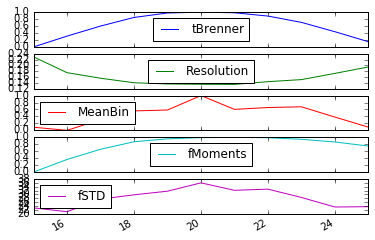

In [37]:
df_res.plot(subplots=True)

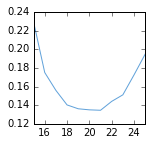

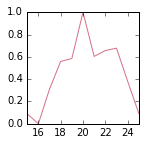

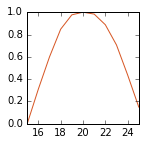

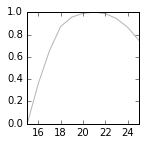

In [38]:
import matplotlib.pyplot as plt

directory = "/Users/sami/Documents/Work/Article manuscripts/2018_FRC:FSC/Data/Figure_Image_Quality"

#x_ticks = list(filename.split("/")[-1].split(".")[:-1][0] for filename in df_sorted["Filename"])

size = (2, 2)
frc_plot = df_res.plot(y='Resolution', figsize=size, legend=False, color='#61a2da')
#frc_plot.set_xticklabels(x_ticks, rotation = -90)
plt.savefig(os.path.join(directory, "focus_resolution.eps"), 
            dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)

fstd_plot = df_res.plot(y='MeanBin', figsize=size, legend=False, color='#d77186')
#fstd_plot.set_xticklabels(x_ticks, rotation = -90)
plt.savefig(os.path.join(directory, "focus_meanbin.eps"), 
            dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)

entropy_plot = df_res.plot(y='tBrenner', figsize=size, legend=False, color='#D75725')
#entropy_plot.set_xticklabels(x_ticks, rotation = -90)
plt.savefig(os.path.join(directory, "focus_brenner.eps"), 
            dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)

entropy_plot = df_res.plot(y='fMoments', figsize=size, legend=False, color='#b5b5b3')
#entropy_plot.set_xticklabels(x_ticks, rotation = -90)
plt.savefig(os.path.join(directory, "focus_spectral_moments.eps"), 
            dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)

